In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import glob

removing isoforms/keeping the highest ranking isoform 

### Setting Working Directories

In [2]:
data_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/analyzed_data/output_files_may22'

In [3]:
input_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng'

In [4]:
fig_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/notebooks/revision/figures'

In [5]:
all_table=pd.DataFrame()
with open(os.path.join(input_dir,'plate_row_list.txt')) as file:
    for line in file:
        for r in ['Downstream', 'Upstream']:
            x = line.strip('\n').split(' ')
            x.append(r)
            fileName = '_'.join(x) + '.txt'
            print('reading file : {}'.format(fileName))
            if os.stat(os.path.join(data_dir,fileName)).st_size != 0:
                t = pd.read_csv((os.path.join(data_dir,fileName)), sep='\t', index_col=0)
                t['RBPmean-NEGmean'] = t['mean']-t.loc['NEG','mean']
                t['|RBPmean-NEGmean|'] = abs(t['RBPmean-NEGmean'])
                t['mean_normalized'] = t['mean']/t.loc['NEG','mean']
                if r=='Downstream':
                    t['reporter']='Downstream'#annotating whether it is upstream or downstream
                elif r=='Upstream':
                    t['reporter']='Upstream'#annotating whether it is upstream or downstream
                all_table=pd.concat([all_table, t])


reading file : GYRBP001_A_Downstream.txt
reading file : GYRBP001_A_Upstream.txt
reading file : GYRBP001_B_Downstream.txt
reading file : GYRBP001_B_Upstream.txt
reading file : GYRBP001_C_Downstream.txt
reading file : GYRBP001_C_Upstream.txt
reading file : GYRBP001_D_Downstream.txt
reading file : GYRBP001_D_Upstream.txt
reading file : GYRBP001_E_Downstream.txt
reading file : GYRBP001_E_Upstream.txt
reading file : GYRBP001_F_Downstream.txt
reading file : GYRBP001_F_Upstream.txt
reading file : GYRBP001_G_Downstream.txt
reading file : GYRBP001_G_Upstream.txt
reading file : GYRBP001_H_Downstream.txt
reading file : GYRBP001_H_Upstream.txt
reading file : GYRBP002_A_Downstream.txt
reading file : GYRBP002_A_Upstream.txt
reading file : GYRBP002_B_Downstream.txt
reading file : GYRBP002_B_Upstream.txt
reading file : GYRBP002_C_Downstream.txt
reading file : GYRBP002_C_Upstream.txt
reading file : GYRBP002_D_Downstream.txt
reading file : GYRBP002_D_Upstream.txt
reading file : GYRBP002_E_Downstream.txt

In [6]:
all_table = all_table.reset_index()

## Removing missing wells

In [7]:
missing_wells = pd.read_csv(os.path.join(input_dir, 'manifest_final_missing_wells.tsv'), sep='\t', header=None)

In [8]:
missing_wells.head()

,0,1,2,3
0,GYRBP001 A,HTATSF1,A10,Down
1,GYRBP001 B,SNRPD2,B4,Up/Down
2,GYRBP001 B,RPL28,B6,Up/Down
3,GYRBP001 C,NOP10,C1,Down
4,GYRBP001 C,NANOS2,C6,Up/Down


In [9]:
missing_wells.shape

(88, 4)

In [10]:
#There are no missing wells all from a single row of a plate
#Double checking this because it requires different code
missing_wells[missing_wells[2]=='All']

,0,1,2,3


In [11]:
def format_well_id_and_categorize(df):
    if int(df[2][1:])<10:  #need this if statement to match how numbers <10 are represented in the MCP library file
        well = df[0].split(' ')[0] + '.' + df[2][0] + '0' + df[2][1:]
    else:   
        well = df[0].split(' ')[0] + '.' + df[2]
    if df[3]=='Down':
        missing['downstream'].append(well)
    elif df[3]=='Upstream':
        missing['upstream'].append(well)
    elif df[3]=='Up/Down':
        missing['upstream'].append(well)
        missing['downstream'].append(well)

missing = {'upstream':[], 'downstream': []}
missing_wells.apply(format_well_id_and_categorize, axis=1)

0     None
1     None
2     None
3     None
4     None
      ... 
83    None
84    None
85    None
86    None
87    None
Length: 88, dtype: object

In [12]:
#Checking that numbers <10 are formatted correctly
missing['upstream'][:5]

['GYRBP001.B04',
 'GYRBP001.B06',
 'GYRBP001.C06',
 'GYRBP001.C07',
 'GYRBP001.C11']

In [13]:
len(missing['upstream'])

83

In [14]:
len(missing['downstream'])

87

In [15]:
all_table[all_table['reporter']=='Upstream'].shape

(1312, 13)

In [16]:
all_table[all_table['reporter']=='Downstream'].shape

(1312, 13)

## Categorizing Upstream and Downstream Results

In [17]:
upstream_results = all_table[all_table['reporter']=='Upstream']

In [18]:
#removing all wells that are in the missing wells dictionary
upstream_results = upstream_results[~upstream_results['well_id'].isin(missing['upstream'])]

In [19]:
upstream_results.shape

(1229, 13)

In [20]:
# using 2 sig figs to make pvalues more interpretable
upstream_results['pvalue'] = upstream_results['pvalue'].apply(lambda x: float(f"{x:.2g}"))

In [21]:
upstream_results.head()

,index,rep1,rep2,rep3,mean,std,pvalue,stars,well_id,RBPmean-NEGmean,|RBPmean-NEGmean|,mean_normalized,reporter
16,NEG,0.708242,0.634997,0.814653,0.719297,0.063878,NaN,NaN,controls,0.000000,0.000000,1.000000,Upstream
17,CPSF5,7.995807,8.223180,9.084158,8.434382,0.468744,0.0015,***,controls,7.715085,7.715085,11.725863,Upstream
18,CPSF6,2.715237,3.115819,4.217557,3.349538,0.635196,0.0270,*,controls,2.630240,2.630240,4.656680,Upstream
19,HNRNPCL1,0.165337,0.213614,0.216191,0.198381,0.023389,0.0058,**,controls,-0.520917,0.520917,0.275798,Upstream
20,CPNE3,0.272727,0.499700,0.473919,0.415449,0.124271,0.0310,*,GYRBP001.A01,-0.303849,0.303849,0.577576,Upstream


In [22]:
downstream_results = all_table[all_table['reporter']=='Downstream']

In [23]:
#removing all wells that in the missing wells dictionary
downstream_results = downstream_results[~downstream_results['well_id'].isin(missing['downstream'])]

In [24]:
downstream_results.shape

(1225, 13)

In [25]:
# using 2 sig figs to make pvalues more interpretable
downstream_results['pvalue'] = downstream_results['pvalue'].apply(lambda x: float(f"{x:.2g}"))

In [26]:
downstream_results.head()

,index,rep1,rep2,rep3,mean,std,pvalue,stars,well_id,RBPmean-NEGmean,|RBPmean-NEGmean|,mean_normalized,reporter
0,NEG,1.073910,1.316469,1.392488,1.260955,0.117653,NaN,NaN,controls,0.000000,0.000000,1.000000,Downstream
1,CPSF5,0.782044,0.950250,0.927488,0.886594,0.074510,0.0400,*,controls,-0.374361,0.374361,0.703113,Downstream
2,CPSF6,1.061556,1.101359,6.000000,2.720972,2.318680,0.4700,NaN,controls,1.460016,1.460016,2.157865,Downstream
3,HNRNPCL1,0.111297,0.119194,0.250000,0.160164,0.063606,0.0024,***,controls,-1.100792,1.100792,0.127018,Downstream
4,CPNE3,1.666667,0.907135,0.793279,1.122360,0.474808,0.6700,NaN,GYRBP001.A01,-0.138595,0.138595,0.890087,Downstream


## Annotating Lists

In [27]:
MCP_list = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/Updated-RBP_V5_MCP.txt', sep='\t').set_index('Symbol')[['Plate Location', 'Gene ID', 'Size', 'Accession', 'nt_sequence', 'aa_sequence']]
Missing_Wells_MCP_list= pd.read_csv('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/Missing_Wells_List.txt', sep='\t').set_index('Symbol')[['Plate Location', 'Gene ID', 'Size', 'Accession', 'nt_sequence', 'aa_sequence']]
Missing_Wells_MCP_list=Missing_Wells_MCP_list.dropna(subset=['Plate Location'])
MCP_list_all = pd.concat([MCP_list, Missing_Wells_MCP_list]).reset_index()


In [28]:
# This includes missing well annotations
MCP_list_all.tail()

,Symbol,Plate Location,Gene ID,Size,Accession,nt_sequence,aa_sequence
1036,DDX41,Missing_Wells.B10,51428.0,1869.0,BC015476.1,ATGGAGGAGTCGGAACCCGAACGGAAGCGGGCTCGCACCGACGAGG...,MEESEPERKRARTDEVPAGGSRSEAEDEDDEDYVPYVPLRQRRQLL...
1037,BCDIN3D,Missing_Wells.A11,144233.0,879.0,BC053560.1,ATGGCGGTGCCCACGGAACTGGATGGAGGGAGTGTTAAGGAGACCG...,MAVPTELDGGSVKETAAEEESRVLAPGAAPFGNFPHYSRFHPPEQR...
1038,RPS10,Missing_Wells.B11,6204.0,498.0,"BC001032.2, BC001955.1, BC005012.1",ATGTTGATGCCTAAGAAGAACCGGATTGCCATTTATGAACTCCTTT...,MLMPKKNRIAIYELLFKEGVMVAKKDVHMPKHPELADKNVPNLHVM...
1039,RPLP0,Missing_Wells.A12,6175.0,954.0,"BC000087.2, BC008092.1, BC008594.1, BC009867.2...",ATGCCCAGGGAAGACAGGGCGACCTGGAAGTCCAACTACTTCCTTA...,MPREDRATWKSNYFLKIIQLLDDYPKCFIVGADNVGSKQMQQIRMS...
1040,LGALS1,Missing_Wells.B12,3956.0,408.0,"BC001693.1, BC020675.1",ATGGCTTGTGGTCTGGTCGCCAGCAACCTGAATCTCAAACCTGGAG...,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...


In [29]:
annotated_upstream_results = pd.merge(upstream_results, MCP_list_all, left_on='well_id', right_on='Plate Location').dropna(subset=['reporter']).dropna(subset=['Plate Location'])

In [30]:
annotated_upstream_results.shape

(901, 20)

In [31]:
annotated_downstream_results = pd.merge(downstream_results, MCP_list_all, left_on='well_id', right_on='Plate Location').dropna(subset=['reporter']).dropna(subset=['Plate Location'])

In [32]:
annotated_downstream_results.shape

(897, 20)

## Remove wells that are repeats from the missing wells plates

In [33]:
m = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/Missing_Wells_List.txt', sep='\t').dropna(subset=['Plate Location'])

In [34]:
missing_wells_duplicates = pd.merge(m,MCP_list.reset_index(),on='aa_sequence', how='inner')[['Plate Location_x', 'Symbol_x', 'Plate Location_y','Symbol_y']].drop_duplicates(subset=['Plate Location_x'])['Plate Location_y'].tolist()

In [35]:
missing_wells_duplicates

['GYRBP004.B04',
 'GYRBP004.F01',
 'GYRBP004.B05',
 'GYRBP004.G01',
 'GYRBP004.B09',
 'GYRBP004.G02',
 'GYRBP004.B10',
 'GYRBP004.G08',
 'GYRBP004.C03',
 'GYRBP004.G12',
 'GYRBP004.C04',
 'GYRBP004.H02',
 'GYRBP004.C08',
 'GYRBP004.H03',
 'GYRBP004.C10',
 'GYRBP004.H04',
 'GYRBP004.D01',
 'GYRBP004.H05',
 'GYRBP004.D10',
 'GYRBP007.H05',
 'GYRBP004.D11',
 'GYRBP002.C05',
 'GYRBP004.E01',
 'GYRBP002.B03']

In [36]:
annotated_upstream_results = annotated_upstream_results[~annotated_upstream_results['well_id'].isin(missing_wells_duplicates)]

In [37]:
annotated_upstream_results.shape

(879, 20)

In [38]:
annotated_downstream_results = annotated_downstream_results[~annotated_downstream_results['well_id'].isin(missing_wells_duplicates)]

In [39]:
annotated_downstream_results.shape

(875, 20)

In [40]:
annotated_downstream_results.drop_duplicates(['Symbol','Accession']).shape

(867, 20)

## Categorize as activator or inhibitor effect

In [41]:
def assign_positive_or_negative(df):
    if (df['RBPmean-NEGmean'] <0) and (df['pvalue']<0.05):
        return 'inhibitor' #inhibitor is equivalent to positive
    elif (df['RBPmean-NEGmean'] >0) and (df['pvalue']<0.05):
        return 'activator' # activator is equivalent to negative
    else:
        return 'neither'

In [42]:
annotated_upstream_results['Effect'] = annotated_upstream_results.apply(assign_positive_or_negative, axis=1)

In [43]:
annotated_upstream_results.head()

,index,rep1,rep2,rep3,mean,std,pvalue,stars,well_id,RBPmean-NEGmean,...,mean_normalized,reporter,Symbol,Plate Location,Gene ID,Size,Accession,nt_sequence,aa_sequence,Effect
0,CPNE3,0.272727,0.499700,0.473919,0.415449,0.124271,0.0310,*,GYRBP001.A01,-0.303849,...,0.577576,Upstream,CPNE3,GYRBP001.A01,8895.0,135.0,BC015734.1,ATGCTTGGAAACAGCATAGATATGTTGCTGTGGTTTTCAGAATTTT...,MLGNSIDMLLWFSEFSLLITRSLLKNDLHIFSCTVKQTEVSLSV,inhibitor
1,SNRPG,0.297710,0.418187,0.474384,0.396760,0.090265,0.0120,*,GYRBP001.A02,-0.322537,...,0.551594,Upstream,SNRPG,GYRBP001.A02,6637.0,231.0,"BC000070.2, BC022432.1, BC066302.1",ATGAGCAAAGCTCACCCTCCCGAGTTGAAAAAATTTATGGACAAGA...,MSKAHPPELKKFMDKKLSLKLNGGRHVQGILRGFDPFMNLVIDECV...,inhibitor
2,SUMO1,0.546217,0.642401,0.639564,0.609394,0.054731,0.1600,NaN,GYRBP001.A03,-0.109903,...,0.847207,Upstream,SUMO1,GYRBP001.A03,7341.0,306.0,"BC006462.1, BC053528.1",ATGTCTGACCAGGAGGCAAAACCTTCAACTGAGGACTTGGGGGATA...,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...,neither
3,FAM32A,0.564965,0.699513,0.554290,0.606256,0.080939,0.1800,NaN,GYRBP001.A04,-0.113041,...,0.842845,Upstream,FAM32A,GYRBP001.A04,26017.0,339.0,"BC000639.1, BC017286.1",ATGGAGGCCTACGAGCAGGTCCAAAAGGGACCCCTGAAGCTGAAAG...,MEAYEQVQKGPLKLKGVAELGVTKRKKKKKDKDKAKLLEAMGTSKK...,neither
4,LSM1,1.071083,1.154260,1.132387,1.119243,0.043118,0.0072,**,GYRBP001.A05,0.399946,...,1.556023,Upstream,LSM1,GYRBP001.A05,27257.0,402.0,BC001767.1,ATGAACTATATGCCTGGCACCGCCAGCCTCATCGAGGACATTGACA...,MNYMPGTASLIEDIDKKHLVLLRDGRTLIGFLRSIDQFANLVLHQT...,activator


In [44]:
annotated_downstream_results['Effect'] = annotated_downstream_results.apply(assign_positive_or_negative, axis=1)

In [45]:
annotated_downstream_results.head()

,index,rep1,rep2,rep3,mean,std,pvalue,stars,well_id,RBPmean-NEGmean,...,mean_normalized,reporter,Symbol,Plate Location,Gene ID,Size,Accession,nt_sequence,aa_sequence,Effect
0,CPNE3,1.666667,0.907135,0.793279,1.122360,0.474808,0.67000,NaN,GYRBP001.A01,-0.138595,...,0.890087,Downstream,CPNE3,GYRBP001.A01,8895.0,135.0,BC015734.1,ATGCTTGGAAACAGCATAGATATGTTGCTGTGGTTTTCAGAATTTT...,MLGNSIDMLLWFSEFSLLITRSLLKNDLHIFSCTVKQTEVSLSV,neither
1,SNRPG,2.266279,2.082801,1.901468,2.083516,0.182407,0.00460,***,GYRBP001.A02,0.822561,...,1.652331,Downstream,SNRPG,GYRBP001.A02,6637.0,231.0,"BC000070.2, BC022432.1, BC066302.1",ATGAGCAAAGCTCACCCTCCCGAGTTGAAAAAATTTATGGACAAGA...,MSKAHPPELKKFMDKKLSLKLNGGRHVQGILRGFDPFMNLVIDECV...,activator
2,SUMO1,1.541465,1.228903,1.625911,1.465426,0.209141,0.26000,NaN,GYRBP001.A03,0.204471,...,1.162156,Downstream,SUMO1,GYRBP001.A03,7341.0,306.0,"BC006462.1, BC053528.1",ATGTCTGACCAGGAGGCAAAACCTTCAACTGAGGACTTGGGGGATA...,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...,neither
3,FAM32A,0.545535,0.597955,0.488889,0.544126,0.054547,0.01100,*,GYRBP001.A04,-0.716829,...,0.431519,Downstream,FAM32A,GYRBP001.A04,26017.0,339.0,"BC000639.1, BC017286.1",ATGGAGGCCTACGAGCAGGTCCAAAAGGGACCCCTGAAGCTGAAAG...,MEAYEQVQKGPLKLKGVAELGVTKRKKKKKDKDKAKLLEAMGTSKK...,inhibitor
4,LSM1,2.961159,3.421189,3.220879,3.201076,0.230653,0.00049,***,GYRBP001.A05,1.940120,...,2.538611,Downstream,LSM1,GYRBP001.A05,27257.0,402.0,BC001767.1,ATGAACTATATGCCTGGCACCGCCAGCCTCATCGAGGACATTGACA...,MNYMPGTASLIEDIDKKHLVLLRDGRTLIGFLRSIDQFANLVLHQT...,activator


In [46]:
annotated_upstream_results.shape

(879, 21)

In [47]:
def make_key(d):
    return f'{d["Symbol"]}_{"_".join([i.strip(" ") for i in str(d["Accession"]).replace(".", "-").split(",")])}'

### Getting/Checking background lists

In [48]:
upstream_background = annotated_upstream_results.copy()
upstream_background = upstream_background[['index', 'Plate Location', 'Accession', 'aa_sequence', 'Symbol','reporter']]

In [49]:
downstream_background = annotated_downstream_results.copy()
downstream_background = downstream_background[['index', 'Plate Location', 'Accession', 'aa_sequence','Symbol','reporter']]

In [53]:
# Everything screened, duplicate sequence well and all 
## (missing wells and re-done wells to fill in missing have been accounted for)
### This is 879 ORFs
all_screened = pd.concat([upstream_background, downstream_background]).drop_duplicates(['index', 'Plate Location', 'Accession', 'aa_sequence'])
#all_screened = pd.concat([upstream_background, downstream_background]).drop_duplicates(['index', 'Plate Location', 'Accession', 'aa_sequence']).to_csv('all_screened.txt', sep='\t', index=False)

In [54]:
all_screened['key'] = all_screened.apply(make_key, axis=1)

##### All screened includes wells that contain the same sequence. 

In [55]:
dubs = all_screened[all_screened.duplicated(['index','Accession','aa_sequence'])]['index'].tolist()

In [56]:
all_screened[all_screened['index'].isin(dubs)].sort_values('index')

,index,Plate Location,Accession,aa_sequence,Symbol,reporter,key
690,FAM120A,GYRBP008.E07,BC098584.1,MGVQGFQDYIEKHCPSAVVPVELQKLARGSLVGGGRQRPPQTPLRL...,FAM120A,Upstream,FAM120A_BC098584-1
875,FAM120A,DNASU002.H11,BC098584.1,MGVQGFQDYIEKHCPSAVVPVELQKLARGSLVGGGRQRPPQTPLRL...,FAM120A,Upstream,FAM120A_BC098584-1
170,NANOS3,GYRBP002.H07,BC101209.2,MGTFDLWTDYLGLAHLVRALSGKEGPETRLSPQPEPEPMLEPVSAL...,NANOS3,Upstream,NANOS3_BC101209-2
815,NANOS3,DNASU002.C07,BC101209.2,MGTFDLWTDYLGLAHLVRALSGKEGPETRLSPQPEPEPMLEPVSAL...,NANOS3,Upstream,NANOS3_BC101209-2
75,PHF5A,GYRBP001.H03,BC007321.2,MAKHHPDLIFCRKQAGVAIGRLCEKCDGKCVICDSYVRPCTLVRIC...,PHF5A,Upstream,PHF5A_BC007321-2
874,PHF5A,DNASU002.H10,BC007321.2,MAKHHPDLIFCRKQAGVAIGRLCEKCDGKCVICDSYVRPCTLVRIC...,PHF5A,Upstream,PHF5A_BC007321-2
820,SNRNP40,DNASU002.D01,BC001494.2,MIEQQKRKGPELPLVPVKRQRHELLLGAGSGPGAGQQQATPGALLQ...,SNRNP40,Upstream,SNRNP40_BC001494-2
880,SNRNP40,Missing_Wells.A04,BC001494.2,MIEQQKRKGPELPLVPVKRQRHELLLGAGSGPGAGQQQATPGALLQ...,SNRNP40,Upstream,SNRNP40_BC001494-2
701,WDR36,GYRBP008.F07,BC133025.1,MCCTEGSLRKRDSQRAPEAVLCLQLWQRTVPLDTLKGLGTCFPSGP...,WDR36,Upstream,WDR36_BC133025-1
808,WDR36,DNASU002.B10,BC133025.1,MCCTEGSLRKRDSQRAPEAVLCLQLWQRTVPLDTLKGLGTCFPSGP...,WDR36,Upstream,WDR36_BC133025-1


In [57]:
# Number of unique sequences screened, but we still screened 879 ORFs
len(set(all_screened['key']))

871

In [58]:
# with open('background_keys_dupseqs_removed.txt', 'w') as bkg_keys:
#     for k in set(all_screened['key']):
#         bkg_keys.write(k + '\n')

In [59]:
# with open('background_decoupler.txt', 'w') as bkg_decoupler:
#     for k in set(all_screened['key']):
#         bkg_decoupler.write(k.split('_')[0] + '\n')

### Focusing on top signal isoforms

In [62]:
aur = annotated_upstream_results.copy()

In [63]:
aur.shape

(879, 21)

In [64]:
aur=aur.dropna(subset=['index'])
aur = aur.sort_values('pvalue', ascending=True).drop_duplicates(subset=['aa_sequence']) # removing duplicates by sequence

In [65]:
aur.shape

(851, 21)

In [66]:
aur['l2_mean_norm'] = np.log2(aur['mean_normalized'])
aur['-log10(pval)'] = -np.log10(aur['pvalue'])

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [67]:
# RALYL was not measured
aur = aur[aur['index']!='RALYL']

In [68]:
aur_sig = aur[aur['pvalue'] < 0.05]

In [69]:
aur_sig.shape

(522, 23)

In [70]:
# using the absolute value to order events
aur['abs_mean_norm'] = np.abs(aur['mean_normalized'])

In [71]:
# keeping only the highest effect isoform for clarity in visualization
aur_filter_iso = aur.dropna(subset='pvalue').sort_values(by=['abs_mean_norm', 'pvalue'], ascending=[False,True]).drop_duplicates(subset=['index', 'Effect'])

In [72]:
aur_top_activator_10 = aur_filter_iso[(aur_filter_iso['pvalue']<0.05) & (aur_filter_iso['l2_mean_norm']>0)].sort_values(by=['l2_mean_norm', 'pvalue'], ascending=[False,True]).head(10)

In [73]:
aur_top_inhibitor_10 = aur_filter_iso[(aur_filter_iso['pvalue']<0.05) & (aur_filter_iso['l2_mean_norm']<0)].sort_values(by=['l2_mean_norm', 'pvalue'], ascending=[True,True]).head(10)

/scratch/pjaganna1/job_7084712/ipykernel_165016/2123507785.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aur_plot = sns.scatterplot(data=aur_filter_iso[aur['pvalue']<0.05], x='l2_mean_norm', y='-log10(pval)', linewidth=0, alpha=0.5, color='#7C5D86')


(-5.0, 5.0)

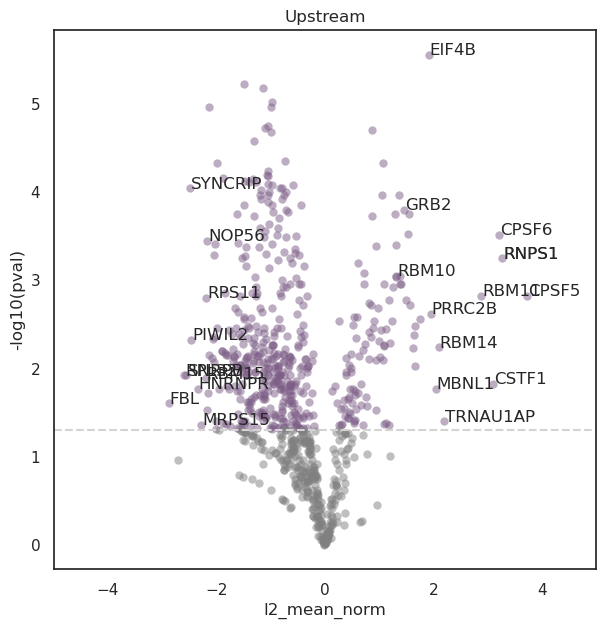

In [74]:
sns.set(rc={'figure.figsize':(7,7)}, style='white')
aur_plot = sns.scatterplot(data=aur_filter_iso[aur['pvalue']<0.05], x='l2_mean_norm', y='-log10(pval)', linewidth=0, alpha=0.5, color='#7C5D86')
sns.scatterplot(data=aur_filter_iso[aur_filter_iso['pvalue']>=0.05], x='l2_mean_norm', y='-log10(pval)', linewidth=0, alpha=0.5, color='grey')
for i, point in aur_top_activator_10.iterrows():
    aur_plot.text(point['l2_mean_norm']+.02, point['-log10(pval)'], str(point['index']))
for i, point in aur_top_inhibitor_10.iterrows():
    aur_plot.text(point['l2_mean_norm']+.02, point['-log10(pval)'], str(point['index']))
for i, point in aur_sig.iterrows():
    if str(point['index']) in ['GRB2', 'RMB22' 'EIF4B', 'RBM10', 'RNPS1']:
        aur_plot.text(point['l2_mean_norm']+.02, point['-log10(pval)'], str(point['index']))
plt.title('Upstream')
plt.axhline(y=-np.log10(0.05), color='lightgrey', linestyle='dashed')
plt.xlim(-5, 5)
# plt.savefig(os.path.join(fig_dir, 'upstream_all_screen_results_iso_filtered.png'))
# plt.savefig(os.path.join(fig_dir, 'upstream_all_screen_results_iso_filtered.svg'))
# plt.savefig(os.path.join(fig_dir, 'upstream_all_screen_results_iso_filtered.jpg'))

In [75]:
adr = annotated_downstream_results.copy()
adr.shape

(875, 21)

In [76]:
adr=adr.dropna(subset=['index'])
adr = adr.sort_values('pvalue', ascending=True).drop_duplicates(subset=['aa_sequence']) # removing duplicates based on sequence

In [77]:
adr['abs_mean_norm'] = np.abs(adr['mean_normalized'])

In [78]:
adr['l2_mean_norm'] = np.log2(adr['mean_normalized'])

In [79]:
adr['-log10(pval)'] = -np.log10(adr['pvalue'])

In [80]:
adr_sig = adr[adr['pvalue'] < 0.05]

In [81]:
adr_filter_iso = adr.dropna(subset='pvalue').sort_values(by=['abs_mean_norm', 'pvalue'], ascending=[False,True]).drop_duplicates(subset=['index', 'Effect'])

In [82]:
adr_top_activator_10 = adr_filter_iso[(adr_filter_iso['pvalue']<0.05) & (adr_filter_iso['l2_mean_norm']>0)].sort_values(by=['l2_mean_norm', 'pvalue'], ascending=[False,True]).head(10)

In [83]:
adr_top_inhibitor_10 = adr_filter_iso[(adr_filter_iso['pvalue']<0.05) & (adr_filter_iso['l2_mean_norm']<0)].sort_values(by=['l2_mean_norm', 'pvalue'], ascending=[True,True]).head(10)

(-5.0, 5.0)

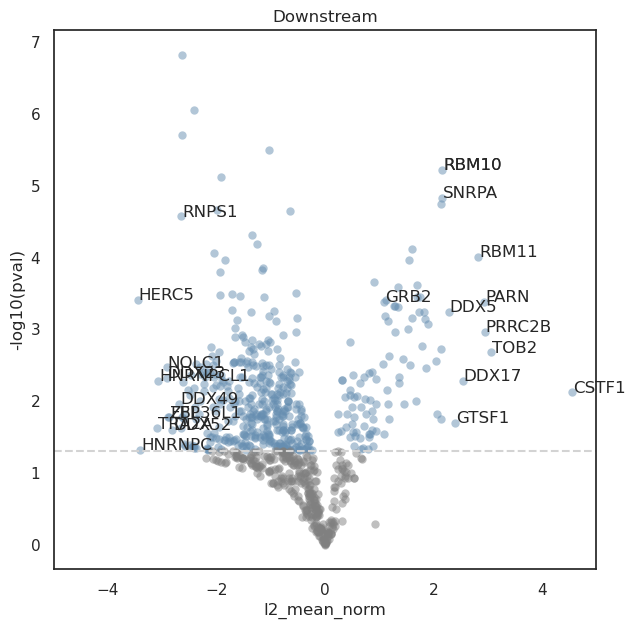

In [84]:
sns.set(rc={'figure.figsize':(7,7)}, style='white')
adr_plot = sns.scatterplot(data=adr_filter_iso[adr_filter_iso['pvalue']<0.05], x='l2_mean_norm', y='-log10(pval)', linewidth=0, alpha=0.5, color='#668EB1')
sns.scatterplot(data=adr_filter_iso[adr_filter_iso['pvalue']>=0.05], x='l2_mean_norm', y='-log10(pval)', linewidth=0, alpha=0.5, color='grey')
for i, point in adr_top_activator_10.iterrows():
    adr_plot.text(point['l2_mean_norm']+.02, point['-log10(pval)'], str(point['index']))
for i, point in adr_top_inhibitor_10.iterrows():
    adr_plot.text(point['l2_mean_norm']+.02, point['-log10(pval)'], str(point['index']))

for i, point in adr_sig.iterrows():
    if str(point['index']) in ['GRB2', 'RMB22' 'EIF4B', 'RBM10', 'RNPS1']:
        adr_plot.text(point['l2_mean_norm']+.02, point['-log10(pval)'], str(point['index']))
plt.title('Downstream')
plt.axhline(y=-np.log10(0.05), color='lightgrey', linestyle='dashed')
plt.xlim(-5, 5)
# plt.savefig(os.path.join(fig_dir, 'downstream_all_screen_results_iso_filtered.png'))
# plt.savefig(os.path.join(fig_dir, 'downstream_all_screen_results_iso_filtered.svg'))
# plt.savefig(os.path.join(fig_dir, 'downstream_all_screen_results_iso_filtered.jpg'))


In [85]:
adr['key'] = adr.apply(make_key, axis=1)

In [86]:
adr.shape

(847, 25)

In [87]:
aur['key'] = aur.apply(make_key, axis=1)

In [88]:
aur.shape

(850, 25)

In [89]:
# number of ORFs screened after removing duplicates
len(set(adr['key']).union(set(aur['key']) ))

854

In [90]:
aur_filter_iso['unique_identifier_2'] = aur_filter_iso.apply(lambda x: f"{x['index']}_{x['Plate Location']}", axis=1)
adr_filter_iso['unique_identifier_2'] = adr_filter_iso.apply(lambda x: f"{x['index']}_{x['Plate Location']}", axis=1)

In [91]:
aur_filter_iso['unique_identifier'] = aur_filter_iso.apply(make_key, axis=1)
adr_filter_iso['unique_identifier'] = adr_filter_iso.apply(make_key, axis=1)

In [92]:
adr_sig.shape

(519, 24)

In [93]:
aur_sig_activator = aur_filter_iso[(aur_filter_iso['Effect'] =='activator') & (aur_filter_iso['pvalue']<0.05)]
aur_sig_inhibitor = aur_filter_iso[(aur_filter_iso['Effect'] =='inhibitor') & (aur_filter_iso['pvalue']<0.05)]
print('Upstream Activator', aur_sig_activator.shape)
print('Upstream Inhibitor', aur_sig_inhibitor.shape)

Upstream Activator (107, 26)
Upstream Inhibitor (380, 26)


In [94]:
adr_sig_activator = adr_filter_iso[(adr_filter_iso['Effect'] =='activator') & (adr_filter_iso['pvalue']<0.05)]
adr_sig_inhibitor = adr_filter_iso[(adr_filter_iso['Effect'] =='inhibitor') & (adr_filter_iso['pvalue']<0.05)]
print('Downstream Activator', adr_sig_activator.shape)
print('Downstream Inhibitor', adr_sig_inhibitor.shape)

Downstream Activator (95, 26)
Downstream Inhibitor (386, 26)


In [95]:
def plot_venn(s1, s2, title, fig_name):
    # Make venn diagram
    venn = venn2([s1, s2], 
                 set_labels=('Upstream', 'Downstream'),
                 set_colors=['#7C5D86', '#668EB1'])
    
    # Increase font sizes
    for label in venn.set_labels:     # the group labels ('Upstream', 'Downstream')
        label.set_fontsize(16)
    
    for label in venn.subset_labels:  # the counts inside the diagram
        if label:  # some can be None
            label.set_fontsize(16)
    
    plt.title(title, fontsize=16)
    # plt.savefig(os.path.join(fig_dir, f'{fig_name}.png'))
    # plt.savefig(os.path.join(fig_dir, f'{fig_name}.svg'))
    # plt.savefig(os.path.join(fig_dir, f'{fig_name}.jpg'))


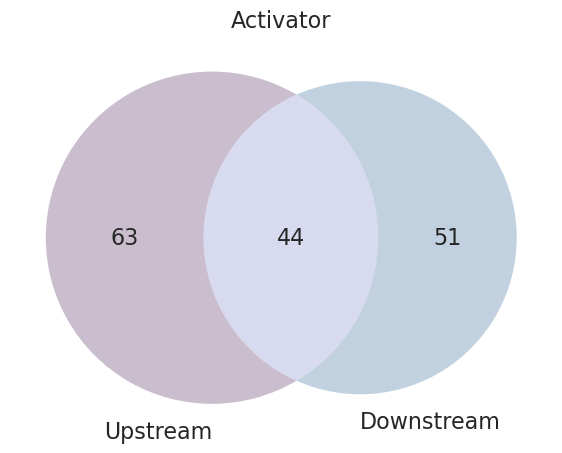

In [96]:
from matplotlib_venn import venn2

set1 = set(aur_sig_activator['unique_identifier'])
set2 = set(adr_sig_activator['unique_identifier'])

v_activator = plot_venn(set1, set2, 'Activator', 'activator_venn_iso_filtered')


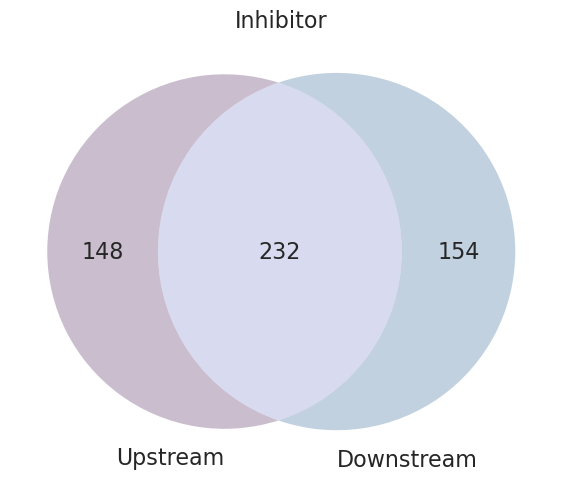

In [97]:
set1 = set(aur_sig_inhibitor['unique_identifier'])
set2 = set(adr_sig_inhibitor['unique_identifier'])

v_inhibitor = plot_venn(set1, set2, 'Inhibitor', 'inhibitor_venn_iso_filtered')


In [ ]:
outdir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/notebooks/revision/iso_filtered_revision/'

In [ ]:
os.path.exists(outdir)

In [ ]:
upstream_activators_noisofilter = aur_sig[(aur_sig['l2_mean_norm'] >0)].sort_values(by=['mean_normalized', 'pvalue'], ascending=[False, True])

In [ ]:
upstream_inhibitors_noisofilter = aur_sig[(aur_sig['l2_mean_norm'] <0)].sort_values(by=['mean_normalized', 'pvalue'], ascending=[False, True])

In [ ]:
downstream_activators_noisofilter = adr_sig[(adr_sig['l2_mean_norm'] >0)].sort_values(by=['mean_normalized', 'pvalue'], ascending=[False, True])

In [ ]:
downstream_inhibitors_noisofilter = adr_sig[(adr_sig['l2_mean_norm'] <0)].sort_values(by=['mean_normalized', 'pvalue'], ascending=[False, True])

In [ ]:
upstream_activators_noisofilter['key'] = upstream_activators_noisofilter.apply(make_key, axis=1)

In [ ]:
upstream_inhibitors_noisofilter['key'] = upstream_inhibitors_noisofilter.apply(make_key, axis=1)

In [ ]:
downstream_activators_noisofilter['key'] = downstream_activators_noisofilter.apply(make_key, axis=1)

In [ ]:
downstream_inhibitors_noisofilter['key'] = downstream_inhibitors_noisofilter.apply(make_key, axis=1)

In [ ]:
#upstream_activators_noisofilter.to_csv(os.path.join(outdir, 'upstream_activators_allisos.txt'), sep='\t', index=False)

In [ ]:
#upstream_inhibitors_noisofilter.to_csv(os.path.join(outdir, 'upstream_inhibitors_allisos.txt'), sep='\t', index=False)

In [ ]:
#downstream_activators_noisofilter.to_csv(os.path.join(outdir, 'downstream_activators_allisos.txt'), sep='\t', index=False)

In [ ]:
#downstream_inhibitors_noisofilter.to_csv(os.path.join(outdir, 'downstream_inhibitors_allisos.txt'), sep='\t', index=False)